# 3a - Visualise the response timescale differences for different glacier models and warming


- Visualises example timeseries and response timescales for different glacier models and climate experiments 
    - creates timeseries for each region/glacier model and all experiments with global warming >=1.2°C. Example time series in **supplementary figure XX**, remaining variants are in `figures/supplements/only_github_supplements/figS5_variants`
    - creates **supplementary figure XX,XX** of "Time to reach 50%/80 % of the changes statistics" 
---
Some technical notes:
- no lowess fit used here, uses response timescale file that got created in the 0_pre_post_processing/0e_response_timescale_estimates.ipynb

In [13]:
# these code lines above are similar to those at the beginning of 2_glacier_vs_climate_change

DATE = 'Feb12_2024' 
fill_option = 'repeat_last_101yrs'

import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous, compute_steady_state_yr, get_glob_temp_exp

path_merged_runs_scaled_extend = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)
ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)

approach = '_via_5yravg'
ds_reg_yr_shift= xr.open_dataset(f'../data/GMIP3_reg_glacier_model_data/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')

pd_global_temp_exp = pd.read_csv('../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b.csv', index_col = 0)


hue_order_anonymous = []
pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
ds_reg_models_extend = ds_reg_models_extend.sel(model_author = hue_order)
pal_models = sns.color_palette(pal_models)

dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
    
# select the right models
glac_models = hue_order
ds_reg_models_extend = ds_reg_models_extend.sel(model_author=glac_models)
ds_reg_models_vol = ds_reg_models_extend.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 

# CHANGED TO MASS ... 
pd_rgi_stats_w_hugonnet = pd.read_csv('../data/3_shift_summary_region_characteristicsFeb12_2024.csv', index_col=[0])
# old dataset pd.read_csv(f'../data/data_from_others/rgi_vs_2020_volume_hugonnet_estimates{DATE}.csv', index_col = [0]) #-> got replaced with the one above: 

['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8']


In [14]:
global_models = ds_reg_models_extend.sel(simulation_year=0).dropna(dim='model_author',how='any').model_author.values

### Supplementary Fig. 5 and other figures... 

In [35]:
# otherwise region's name is too long
d_reg_num_name['19'] = 'Subantarctic &\nAntarctic Islands'
d_reg_num_name['12'] = 'Caucasus &\nMiddle East'
d_reg_num_name['05'] = 'Greenland\nPeriphery'
d_reg_num_name['07'] = 'Svalbard &\nJan Mayen'

{'01': 'Alaska',
 '02': 'W Canada & US',
 '03': 'Arctic Canada N',
 '04': 'Arctic Canada S',
 '05': 'Greenland\nPeriphery',
 '06': 'Iceland',
 '07': 'Svalbard &\nJan Mayen',
 '08': 'Scandinavia',
 '09': 'Russian Arctic',
 '10': 'North Asia',
 '11': 'Central Europe',
 '12': 'Caucasus &\nMiddle East',
 '13': 'Central Asia',
 '14': 'South Asia W',
 '15': 'South Asia E',
 '16': 'Low Latitudes',
 '17': 'Southern Andes',
 '18': 'New Zealand',
 '19': 'Subantarctic &\nAntarctic Islands'}

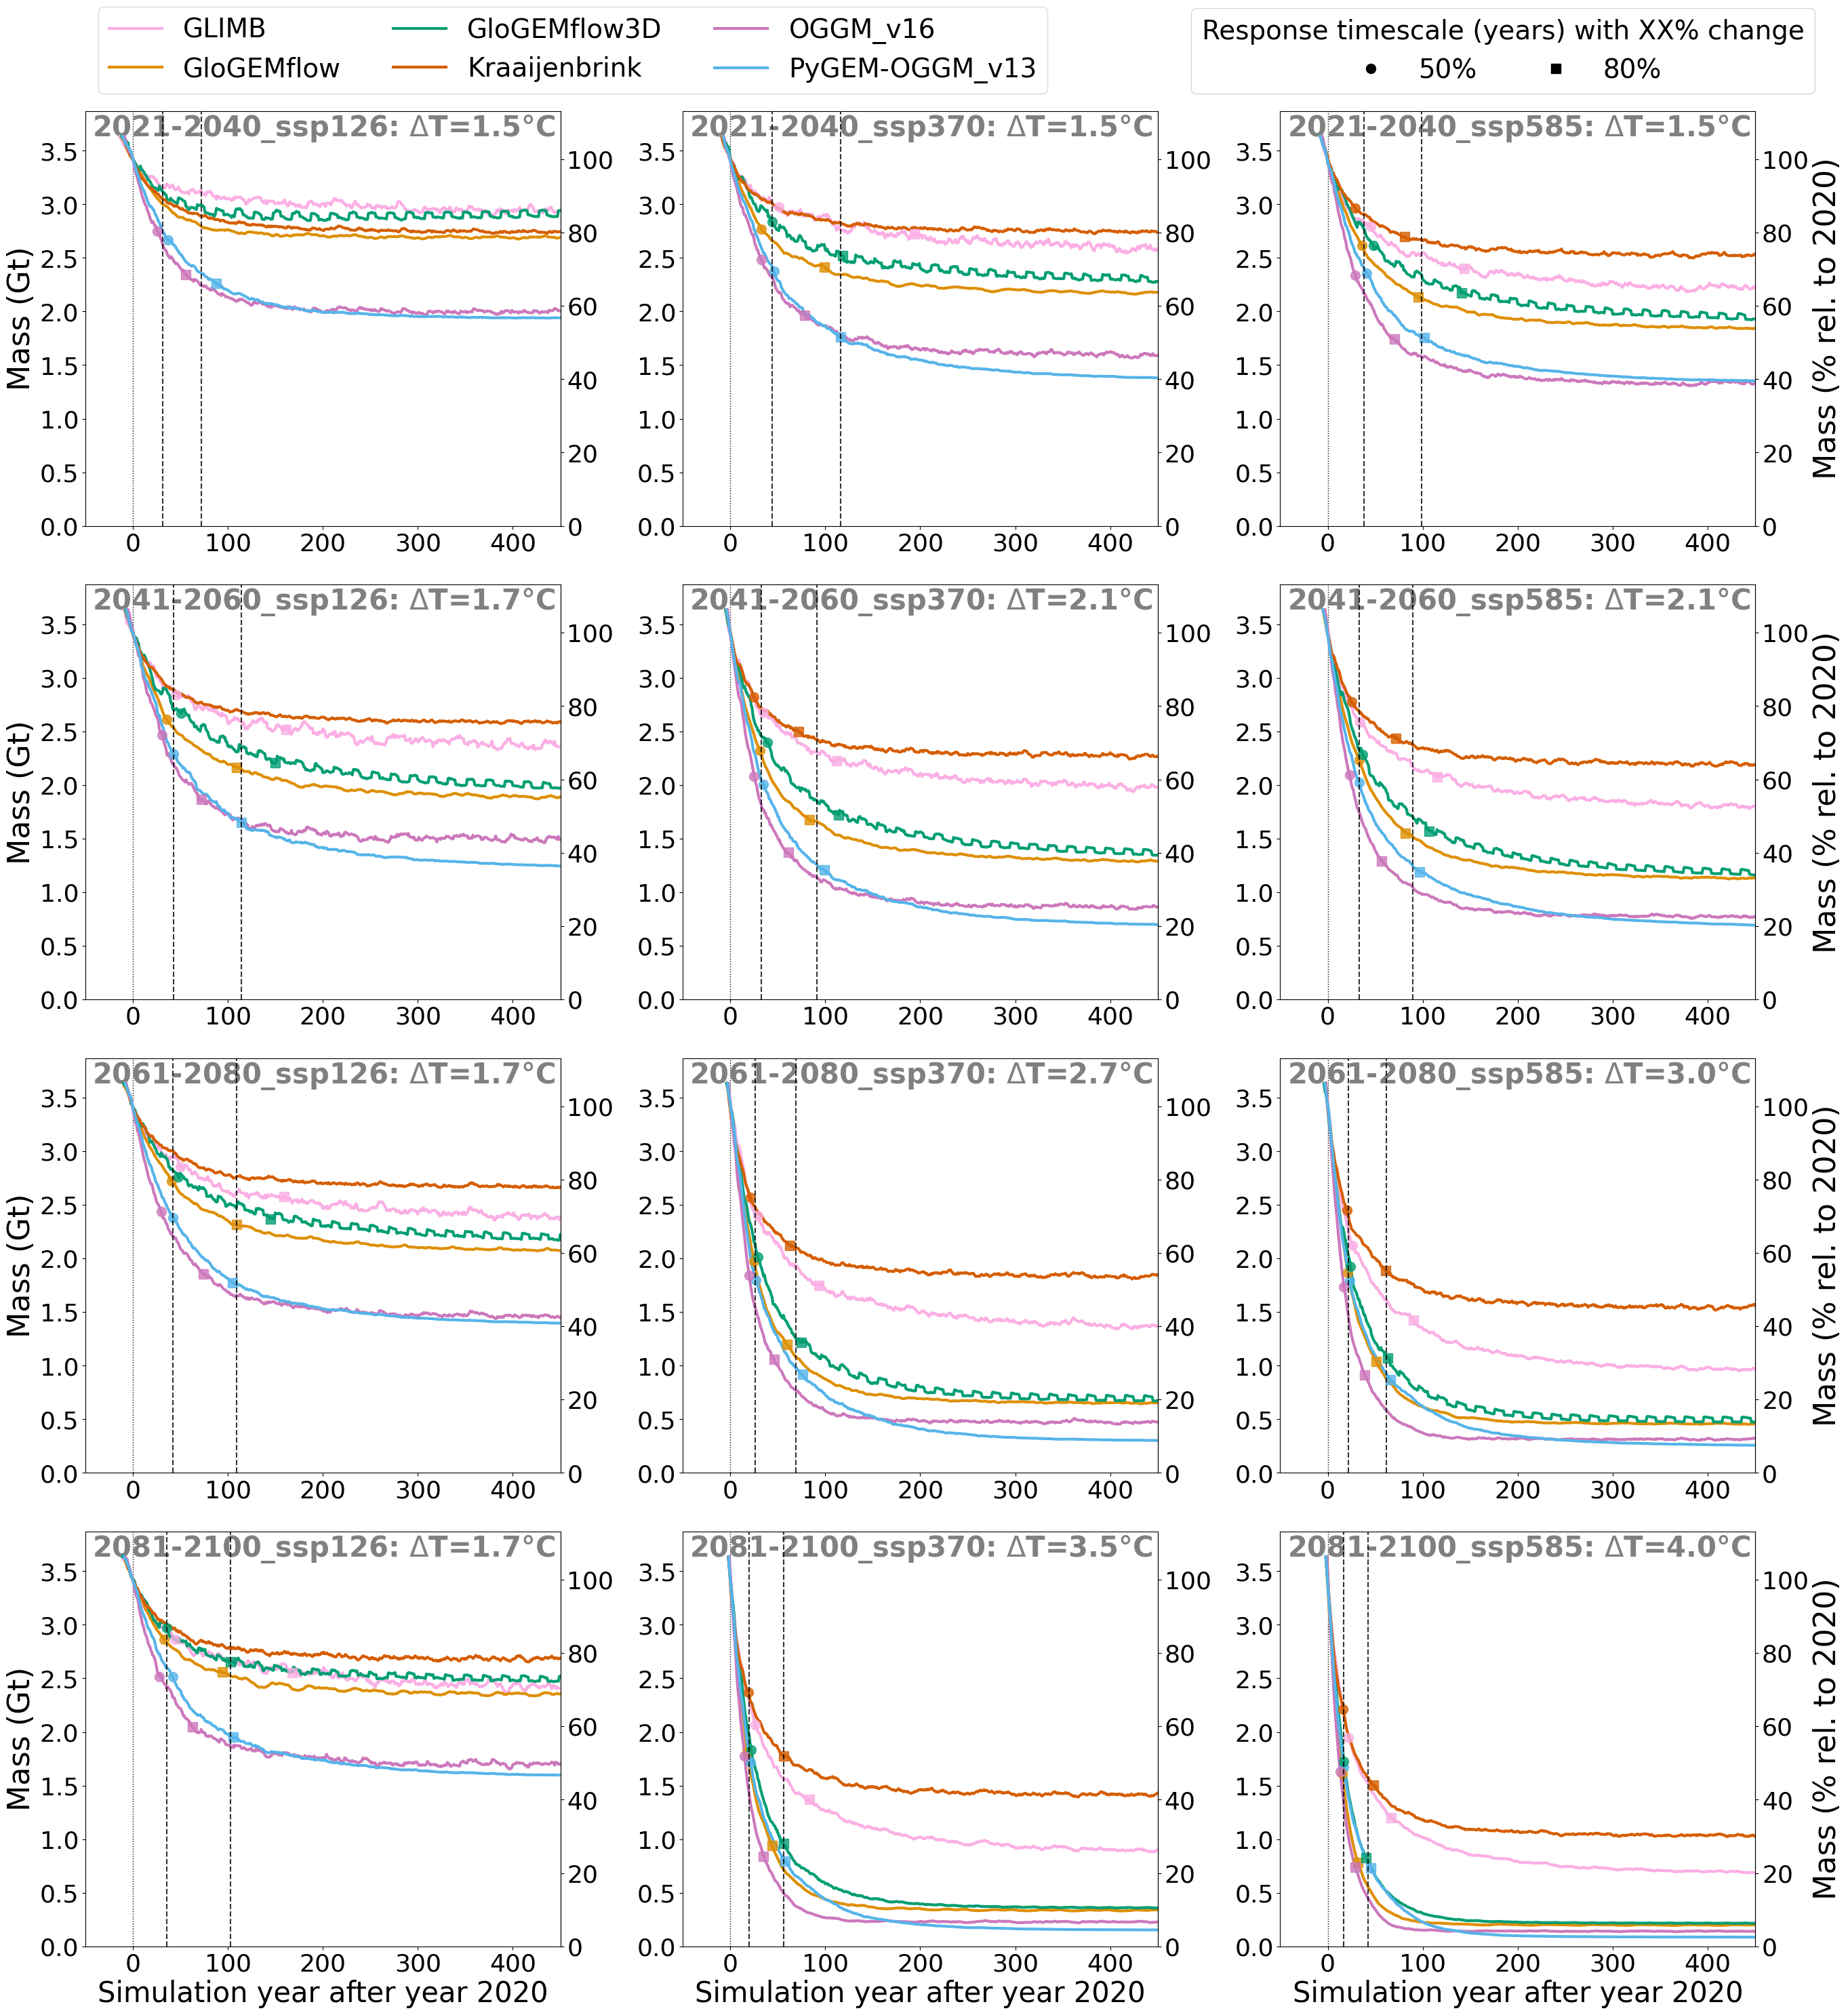

In [15]:
plt.rc('font', size=26) 

shift_years = True

# only compatible with shifted simulation years now
assert shift_years
p_add = '_shifted'
roll_volume=21 # 20
min_perc_change = 25

pd_response_time_x_perc_loss_comp = pd.read_csv(f'../data/resp_time{p_add}_for_deltaT_rgi_reg_roll_volume_{roll_volume}yravg.csv', index_col=[0])

anonym = ['']
ls = 'solid'
only_80 = False 
sel_periods =pd_global_temp_exp.loc[pd_global_temp_exp.temp_ch_ipcc>=1.2]['period_scenario'].unique()
fig_count = 0
for gcm in ['mpi-esm1-2-hr','gfdl-esm4','ipsl-cm6a-lr','mri-esm2-0','ukesm1-0-ll']:
    for rgi_reg in ['13','01', '02', '03', '04', '05','06', '07', '08', '09', '10', '11', '12',
                    '14', '15', '16', '17', '18', '19']: ## only '13' is shown in the supplements... 
        try:
            int(rgi_reg)
            _rgi_reg = f'RGI{rgi_reg}'
        except:
            _rgi_reg = rgi_reg
        if rgi_reg in ['04','06']:
            set_ylim1 = 5000
            show_rt_text = False
        else:
            set_ylim1 = 450
            show_rt_text = False
        vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg][f'regional_volume_m3_2020{approach}']
        mass_2020_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg][f'regional_volume_m3_2020{approach}']/900

        def vol_rel_2020_to_vol_km3(x, _vol_2020_reg = mass_2020_reg):
            return x*_vol_2020_reg/1e9/100
        def vol_km3_to_vol_rel_2020(x, _vol_2020_reg = mass_2020_reg):
            return x*1e9*100/_vol_2020_reg
        plt.figure(figsize=(27.5,30))
        axs = []
        for j,period_scenario in enumerate(sel_periods):
            condi3 = (pd_global_temp_exp.period_scenario==period_scenario)
            temp_ch = pd_global_temp_exp.loc[(pd_global_temp_exp.gcm==gcm) & condi3]['temp_ch_ipcc'].round(1).values.squeeze()

            if j==0:
                ax0=plt.subplot(4,3,j+1)
                ax = ax0
            else:
                order_ax = [1,4,7,10, 2,5,8,11,3,6,9,12]
                ax=plt.subplot(4,3,order_ax[j],sharey=ax0)
            axs.append(ax)
            if shift_years:
                # we shift by maximum by +100 years, so like that there should always be values inside 
                pd_reg_vol_sel = ds_reg_yr_shift.sel(year_after_2020=slice(-100,4900)).volume_m3.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).to_dataframe().reset_index()
                xx = 'year_after_2020'
            else:
                pd_reg_vol_sel = ds_reg_models_vol.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).to_dataframe().reset_index()
                xx = 'simulation_year'
            pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
            pd_reg_vol_sel['mass (Gt)'] = pd_reg_vol_sel['volume_m3']/1e9/900 
            #var = 'volume (km³)'
            var = 'mass (Gt)'

            pd_reg_vol_sel = pd_reg_vol_sel.dropna()
            dict_model_col_reg = {}
            for m in pd_reg_vol_sel.model_author.unique():
                dict_model_col_reg[m] = dict_model_col[m]
            if ls == 'solid' and j==0:
                sns.lineplot(x=xx, data=pd_reg_vol_sel, y=var, #'volume (km³)',
                         hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax)
            else:
                sns.lineplot(x=xx, data=pd_reg_vol_sel, y=var, #'volume (km³)',
                         hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax)


            if j <4: #,3,6,9]: #4,8,12]:
                #plt.ylabel('Volume (km³)', fontsize=22)
                plt.ylabel('Mass (Gt)', fontsize=32) #, weight=)
            else:
                plt.ylabel('')

            if shift_years:
                plt.xlabel('Simulation year after year 2020', fontsize=30)
            else:
                plt.xlabel('Simulation year', fontsize=28)
            if j not in [3,7,11]: #9:
                plt.xlabel('')
            if j==1:
                minip, maxip = ax.get_ylim()
            elif j==3:
                minif, maxif = ax.get_ylim()
            
            for st,perc in zip(['o','s'],[-50,-80]):
                if only_80 and perc == -50:
                    continue
                yrs_l = []
                for m,c in zip(dict_model_col.keys(),dict_model_col.values()):

                    # get the response timescale 
                    _pd_rgi_reg = pd_response_time_x_perc_loss_comp.loc[pd_response_time_x_perc_loss_comp.rgi_reg==_rgi_reg]
                    _pd_rt = _pd_rgi_reg.loc[_pd_rgi_reg.model_author == m]
                    _pd_rt.index = _pd_rt.gcm_period_scenario
                    try:
                        yr = _pd_rt.loc[_pd_rt.index == f'{gcm}_{period_scenario}'][f'resp_time_{perc}%'].values[0]
                    except:
                        yr = np.NaN

                    if not np.isnan(yr):
                        pd_vol_reg_m_sel = pd_reg_vol_sel.loc[pd_reg_vol_sel.model_author==m]

                        y = pd_vol_reg_m_sel.loc[pd_vol_reg_m_sel[xx]==yr][var].values.squeeze()
                        plt.plot([yr], [y], st, color=c, ms=10, alpha = 0.8)
                        yrs_l.append(yr)
                if len(yrs_l)>=1:  
                    yr_med = np.median(np.array(yrs_l))
                    plt.axvline([yr_med], color='black', alpha = 0.8,lw=1.5, ls='--')
                    if show_rt_text:
                        #if j ==2:
                        _,ylim_max = plt.gca().get_ylim()
                        if perc == -80:
                            if only_80:
                                plt.text(yr_med+0.5,ylim_max/100,f'median:{int(yr_med)} years', fontsize=22)
                            else:
                                if j!=4:
                                    plt.text(yr_med+0.5,ylim_max/100,f'{int(yr_med)}', fontsize=22)
                                else:
                                    plt.text(yr_med+0.5,ylim_max/100,f'{str(perc)[1:]}%\n{int(yr_med)} years',
                                             fontsize=22)
                        else:
                            if j!=4:
                                plt.text(yr_med+0.5,ylim_max/100,f'{int(yr_med)}', fontsize=22)
                            else:
                                plt.text(yr_med+0.5,ylim_max/100,f'median:\n{str(perc)[1:]}%\n{int(yr_med)}',
                                         fontsize=22)

            ax.set_xlim([-50,set_ylim1])

            ax2 = ax.secondary_yaxis(1., functions=(vol_km3_to_vol_rel_2020, 
                                     vol_rel_2020_to_vol_km3))

            if j >= 8: #[2]: #,5,8,11]: #[3]:
                ax2.set_ylabel('Mass (% rel. to 2020)', fontsize=32) #, weight='bold') # volume
            else:
                ax2.set_ylabel('')

            if j==0: 
                _leg = ax.get_legend()
                handles, labels = ax.get_legend_handles_labels()
                _leg.remove()
                models_reg = pd_reg_vol_sel.model_author.unique()
                n = len(models_reg)
                dict_model_col_reg_p = {}
                list_reg_model_anonym = []
                for p in dict_model_col_reg.keys():
                    list_reg_model_anonym.append(model_order_anonymous[p])

                
                if rgi_reg == '11':
                    loc = 'upper right'
                    bbox_to_anchor = (0.99,0.92)
                else:
                    loc = 'lower left'
                    bbox_to_anchor = (0,0)
                loc = 'lower left'
                bbox_to_anchor=(0,1.01) # -0.14) #(0,-0.14)

                leg = ax.legend(handles, dict_model_col_reg.keys(), #title=f'{n} models',
                                loc=loc,
                                framealpha = 0.7,
                               bbox_to_anchor=bbox_to_anchor, ncol=3, fontsize=28
                               )
                for legobj in leg.legendHandles:
                    legobj.set_linewidth(3.0)
                leg.set_zorder = 5
                minip, maxip = ax.get_ylim()
                ax0 = ax
                ax.get_legend().remove()
            ax.set_ylim([0,maxip*1.02])
            ax.text(0.99,0.94, str(period_scenario) +r': $\Delta$T'+f'={temp_ch}°C', color='grey', 
                    fontsize=30, transform=ax.transAxes, zorder=0, horizontalalignment='right', weight='bold')
            if j==0: #2 or j==5:
                from matplotlib.lines import Line2D
                import matplotlib.patches as mpatches
                handles = []
                # from data
                # create manual symbols for legend
                point1 = Line2D([0], [0], label='manual point', marker='o', markersize=10, 
                         markeredgecolor='k', markerfacecolor='k', linestyle='')
                point2 = Line2D([0], [0], label='manual point', marker='s', markersize=10, 
                         markeredgecolor='k', markerfacecolor='k', linestyle='')
                # add manual symbols to auto legend
                handles.extend([point1, point2])
                if only_80:
                    leg0=plt.legend(handles=handles, labels=['80% of\ntotal change'], 
                               #title='XX% of\ntotal change:', 
                               loc='lower right',
                               title_fontsize=18, fontsize=18)
                else:
                    leg0=plt.legend(handles=handles, labels=['50%','80%'],
                               title='Response timescale (years) with XX% change', loc='lower left',
                               title_fontsize=28, fontsize=28, ncol=2,
                                   bbox_to_anchor=(2.3,1.01))
                #ax.add_artist(leg)
                ax.get_legend().remove()
            ax.axvline(0,ls=':', color='black', lw=1, zorder=-1)
            ax.axhline(vol_2020_reg/1e9,ls=':', color='black', lw=1, zorder=-1)

        reg = d_reg_num_name[rgi_reg]
        plt.tight_layout(rect=(0,0,1,0.96))# 0.017,1,1))
        
        #handles = []
        #labels = []
        #for m in dict_model_col.keys():
        #    line = Line2D([0], [0], color=dict_model_col[m], ms=8, marker='s', lw=0, alpha = 0.8)
        #    if m=='Kraaijenbrink':
        #        label='Kraaijenbrink' #RA2017'
        #    else:
        #        label = m
        #    handles.append(line)
        #    labels.append(label)
        #axs[4][0].legend(handles, labels,#title='glacier models',
        #            loc = 'upper left', fontsize=26, bbox_to_anchor=(0,-0.14), ncol=6)
        ax0.add_artist(leg)
        ax0.add_artist(leg0)
        if gcm == 'mpi-esm1-2-hr' and rgi_reg=='13':
            plt.savefig('figures/supplements/suppl_fig_5.pdf')
            plt.savefig('figures/supplements/suppl_fig_5.png')
        else:
            if shift_years:
                #plt.savefig(f'figures/supplements/only_github_supplements/figS5_variants/shifted_sel_manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_w_resp_time_rel_2020_{DATE}.png')
                plt.savefig(f'figures/supplements/only_github_supplements/figS5_variants/shifted_sel_manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_w_resp_time_rel_2020_{DATE}.pdf')
            else:
                plt.savefig(f'figures/supplements/only_github_supplements/sel_manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_w_resp_time_rel_2020_{DATE}.png')
        if fig_count>=1:
            plt.close()
        fig_count+=1


#### complex plot for all RGI regions ...

In [5]:
pd_rgi_stats_w_hugonnet.loc[pd_rgi_stats_w_hugonnet.index,'%_2020_rel_global'] = (100*pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_5yravg']/pd_rgi_stats_w_hugonnet.loc['All']['regional_volume_m3_2020_via_5yravg']).values
pd_hugo_far_reg = pd_rgi_stats_w_hugonnet.drop('All')
rgi_regs_sel_sorted_vol = pd_hugo_far_reg.sort_values(by='%_2020_rel_global', ascending=False).index.values


In [6]:
p_add = '_shifted'

roll_volume=21 
min_perc_change = 25

pd_response_time_x_perc_loss_comp = pd.read_csv(f'../data/resp_time{p_add}_for_deltaT_rgi_reg_roll_volume_{roll_volume}yravg.csv', index_col=[0])


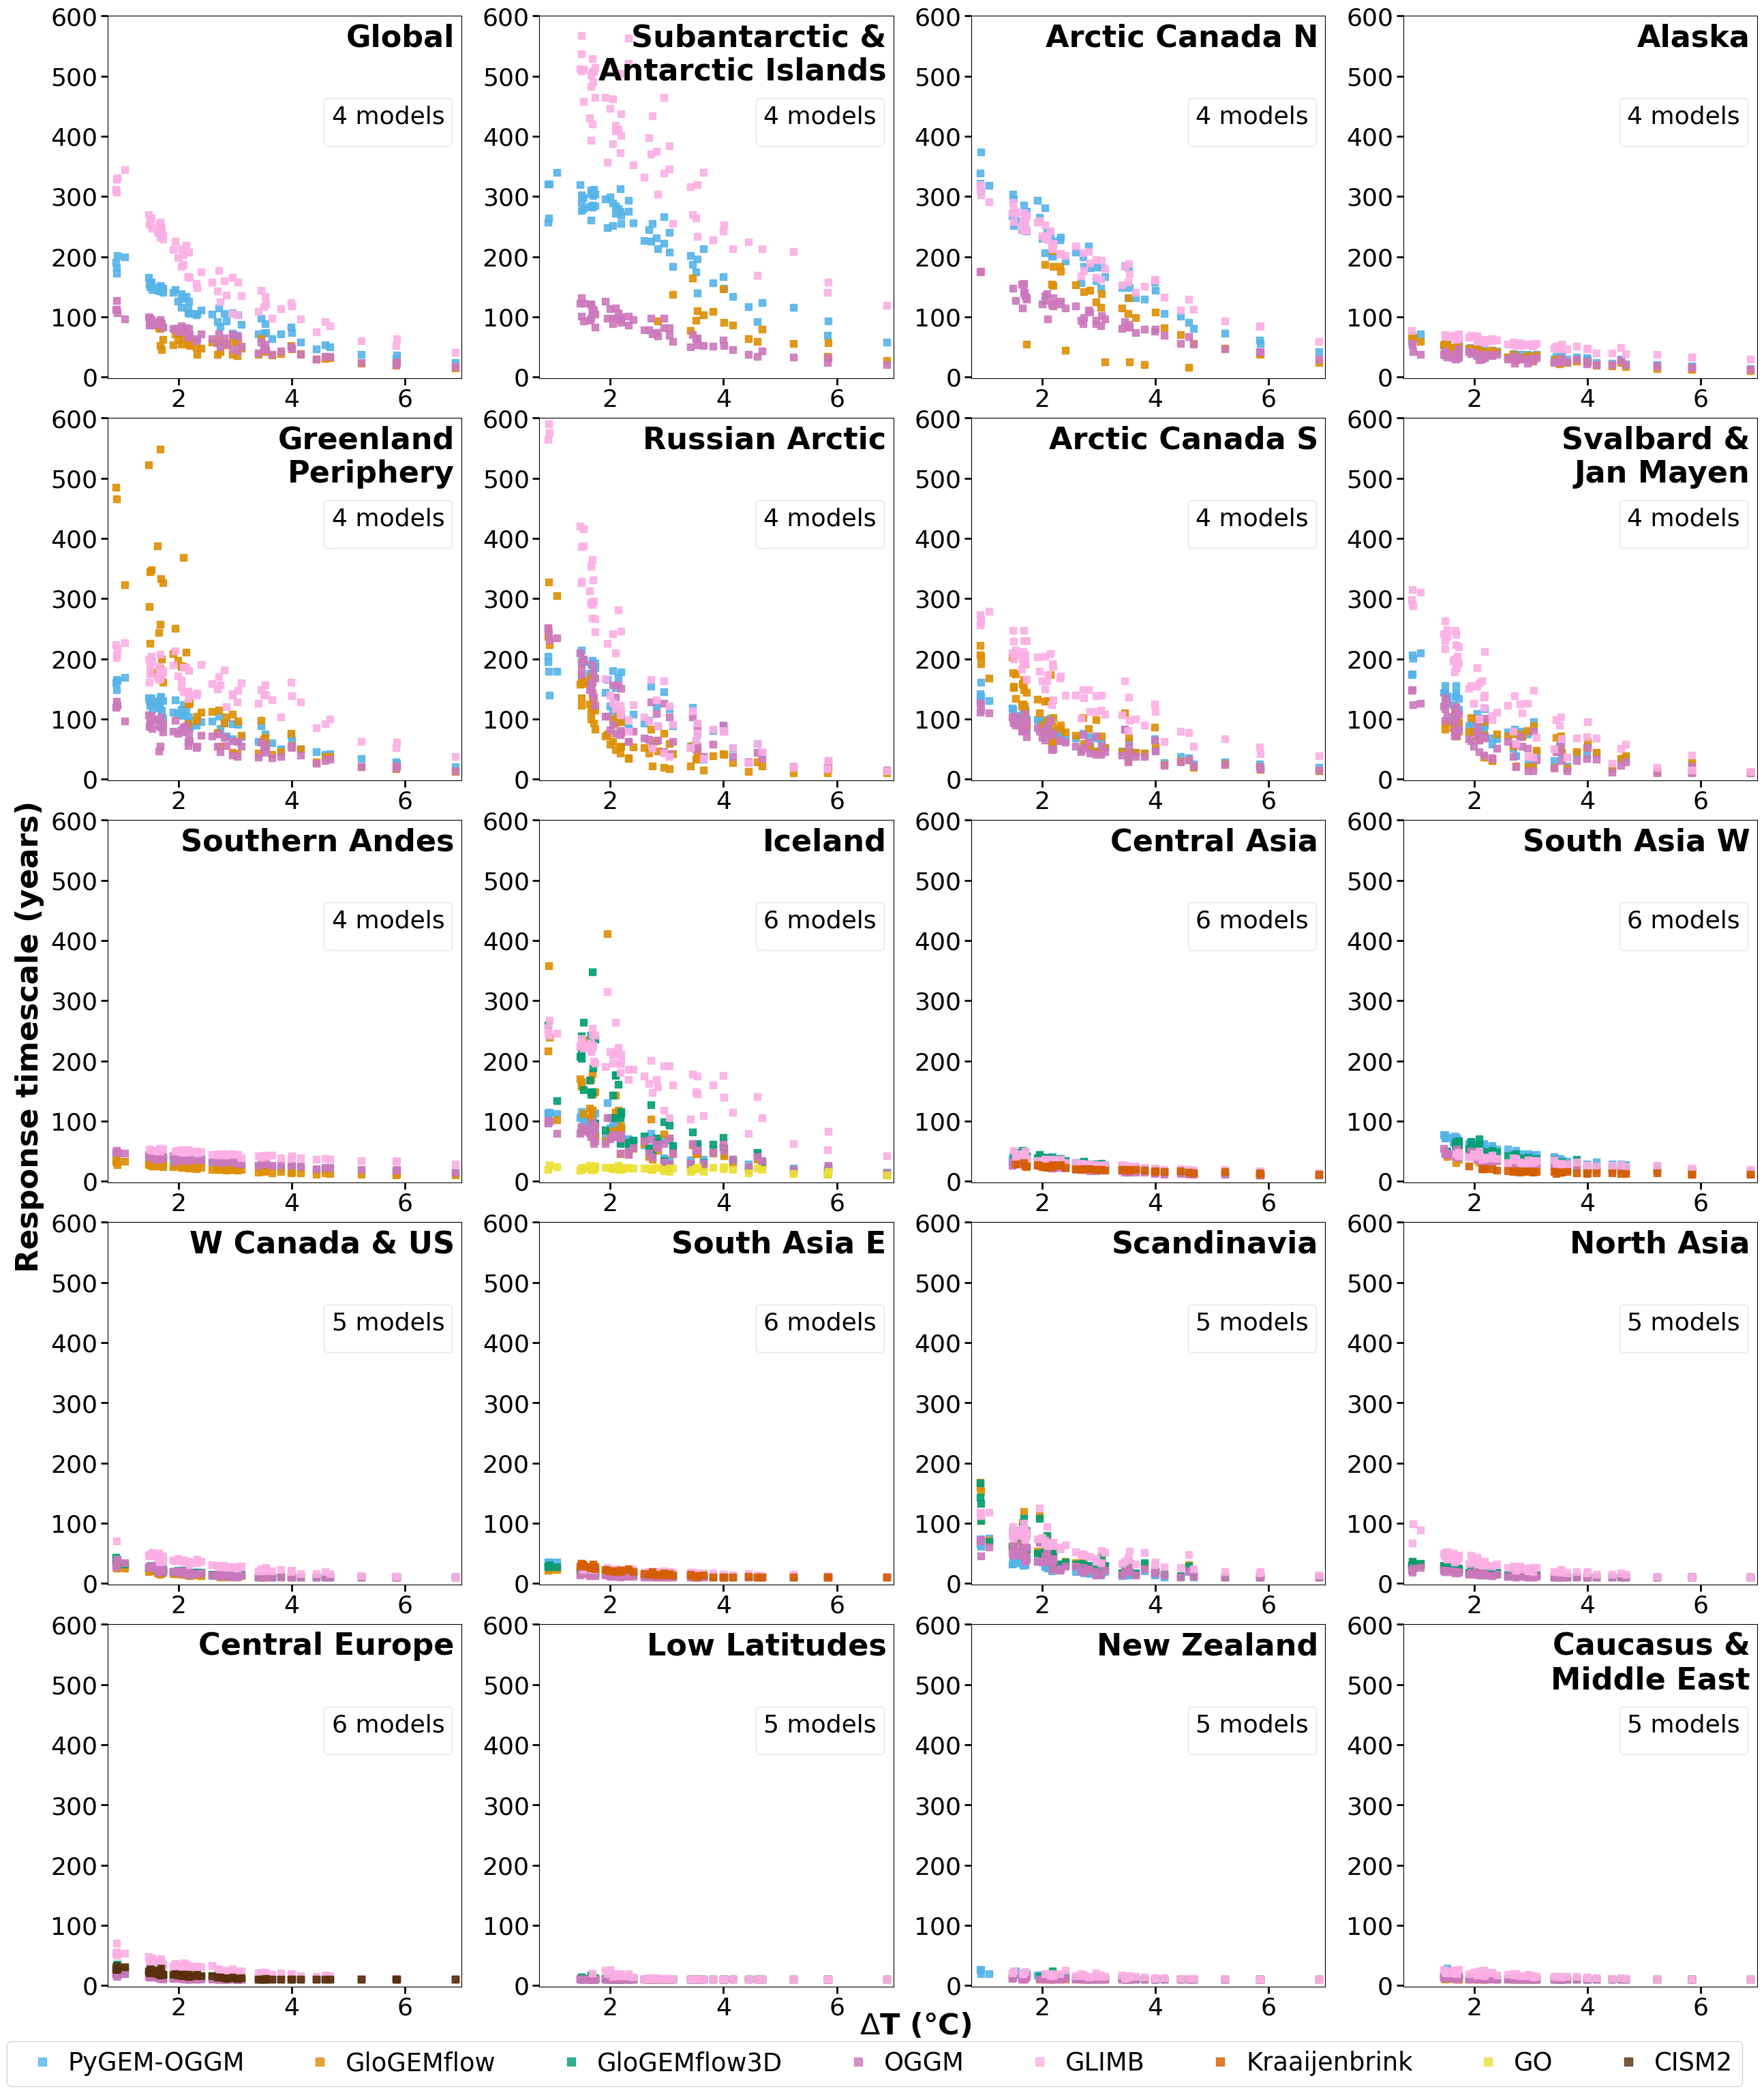

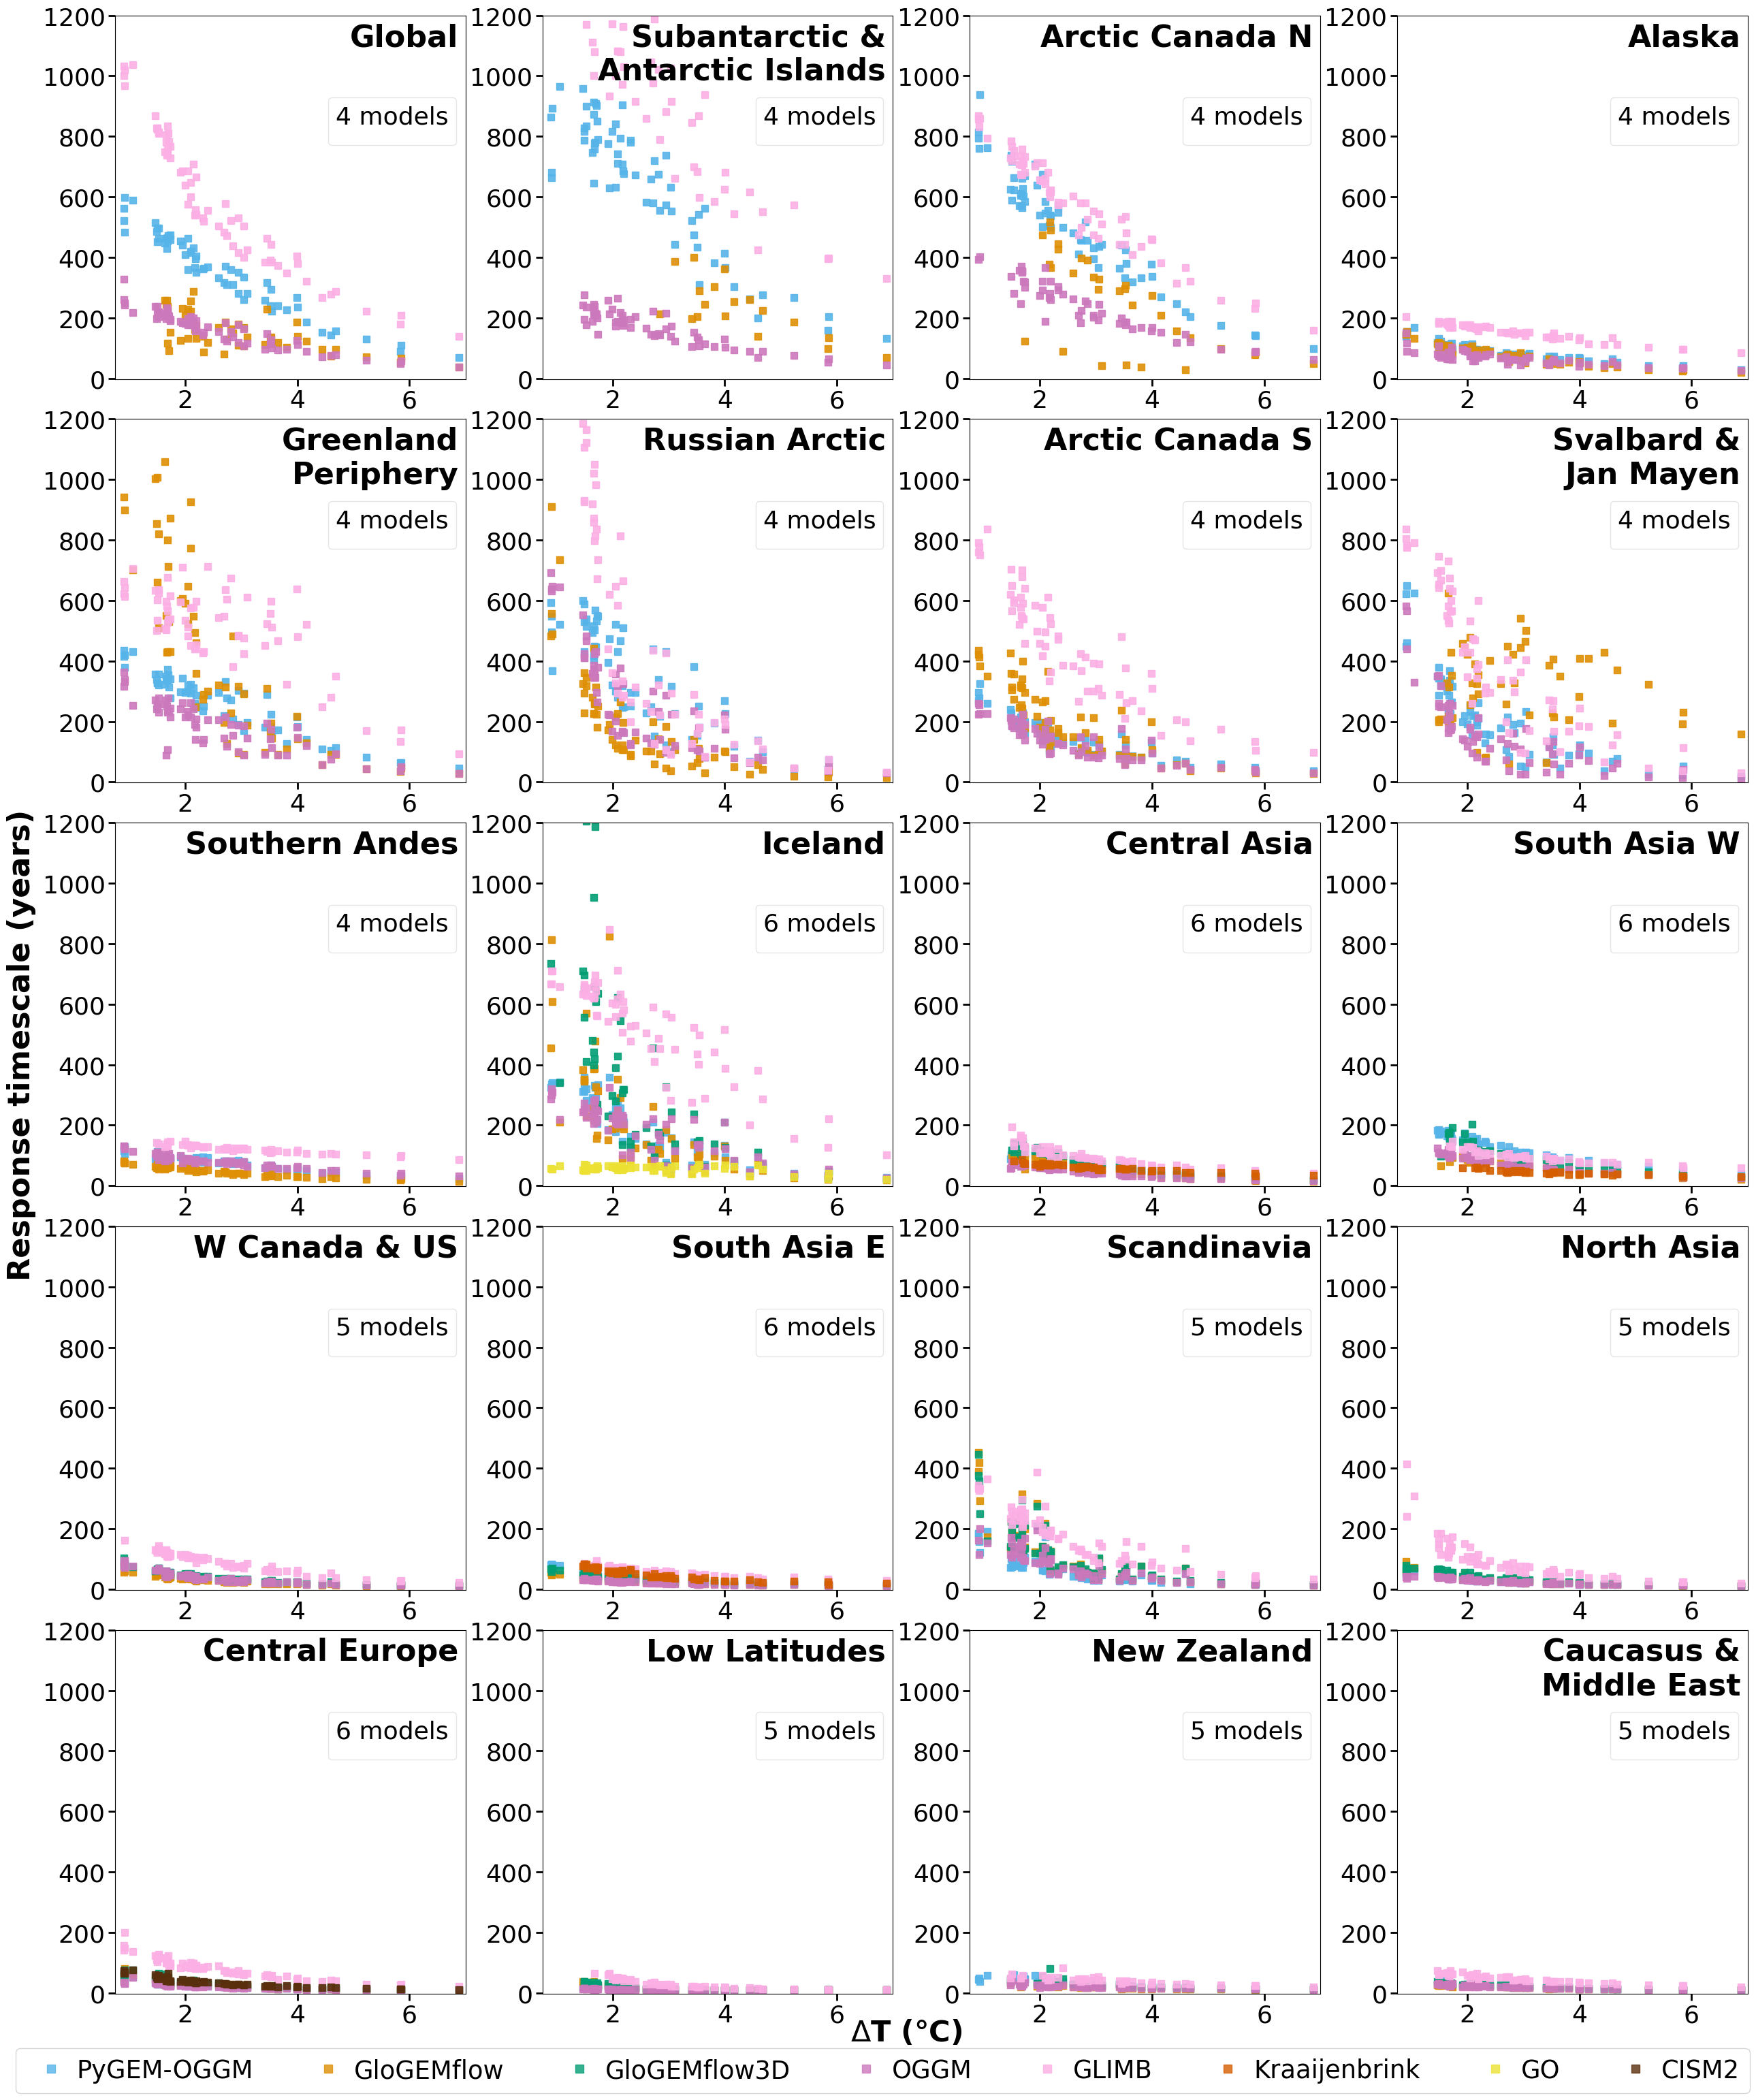

In [34]:
 

# only compatible to shifted years now... 
if shift_years:
    # we shift by maximum by +50 years, so like that there should always be values inside 
    _ds_reg_models_extend = ds_reg_yr_shift.sel(year_after_2020=slice(0,4950))
    xx = 'year_after_2020'
    pd_reg_models_count = _ds_reg_models_extend.volume_m3.sel(year_after_2020=0).to_dataframe().groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
    p_add = '_shifted'
    lab_add = 'after 2020 '

pd_response_time_x_perc_loss_comp = pd.read_csv(f'../data/resp_time{p_add}_for_deltaT_rgi_reg_roll_volume_{roll_volume}yravg.csv', index_col=[0])


pd_reg_models_count = pd_reg_models_count.loc[pd_reg_models_count.rgi_reg !='All']
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})
# models available for each region...
_regional_model = pd_reg_models_count.loc[pd_reg_models_count.n_experiments > 0 ] # ==80

## amount of models per region
# at least 1 experiment for that RGI region
reg_n_models = pd_reg_models_count.loc[pd_reg_models_count.n_experiments > 0].groupby('rgi_reg').count()['model_author'] 
# models that are globally available 
max_exps=pd_reg_models_count.n_experiments.max()
global_models = pd_reg_models_count.groupby('model_author').sum().where(pd_reg_models_count.groupby('model_author').sum().n_experiments == 19 * max_exps).dropna().index


for perc in [-50,-80]: #,-90]: 

    fig, axs = plt.subplots(5,4,figsize=(26,31)) #, sharey='row') #, sharex=True)
    rgi_regs_global = ['All'] + list(rgi_regs_sel_sorted_vol)  # after initial volume ...
    
    
    if perc>0:
        perc_change_i = f'+{perc}'
    else:
        perc_change_i = str(perc)
        
    for j, rgi_reg in enumerate(rgi_regs_global):
        if j<4:
            ax = axs[0][j]
        elif j <8:
            ax = axs[1][j-4]
        elif j <12:
            ax = axs[2][j-8]
        elif j <16:
            ax = axs[3][j-12]
        elif j <20:
            ax = axs[4][j-16]
        try:
            int(rgi_reg)
            _rgi_reg = f'RGI{rgi_reg}'
        except:
            _rgi_reg = rgi_reg
        _pd_rgi_reg = pd_response_time_x_perc_loss_comp.loc[pd_response_time_x_perc_loss_comp.rgi_reg==_rgi_reg]
    
        if rgi_reg == 'All':
            # only take models that exist globally
            # at the moment Rounce, Glimb, OGGM,GloGEMflow
            n = len(global_models)
            mj = 0
            for c,m in zip(pal_models, model_order):
                if m in global_models:
                    mj+=1
    
                    label = m
                    _pd_m_rgi_reg = _pd_rgi_reg.loc[_pd_rgi_reg.model_author == m]
                    ax.plot(_pd_m_rgi_reg['temp_ch_ipcc'],
                             _pd_m_rgi_reg[f'resp_time_{perc_change_i}%'], 's',
                                markersize=7, lw=0, color=c, label = label, alpha = 0.9)
                else:
                    pass
    
        else:    
            models_available = _regional_model.loc[_regional_model.rgi_reg==rgi_reg]['model_author'].values
            n = reg_n_models[rgi_reg]
            mj=0
            for c,m in zip(pal_models, model_order):
                if m in models_available:
                    mj+=1
                    label = m
                    _pd_m_rgi_reg = _pd_rgi_reg.loc[_pd_rgi_reg.model_author == m]
                    ax.plot(_pd_m_rgi_reg['temp_ch_ipcc'],
                             _pd_m_rgi_reg[f'resp_time_{perc_change_i}%'], 's',
                                                             markersize=7, lw=0, color=c, label = label, alpha = 0.9)
    
        handles, labels = ax.get_legend_handles_labels()
        leg1 = ax.legend([],[], #handles, labels,
                         title =f'{n} models', fontsize=20,
                         framealpha=0.5, loc='upper right', bbox_to_anchor=(1,0.8))
        if rgi_reg == '11':
            # need to readd Central Europe 
            leg_11 = leg1
        if perc<0:
            ax.set_ylabel(f'Response timescale (years)', fontsize=28) # of total volume loss occurs')
        else:
            ax.set_ylabel(f'Simulation year {lab_add}when\n{perc_change_ii}% of total volume gain occurs')
        if j != 0:
            ax.set_ylabel('')
        ax.set_xlabel(r'$\Delta$T (°C)') 
        if rgi_reg != 'All':
            nam = d_reg_num_name[rgi_reg]
            #if rgi_reg == '19':
            #    fs_rgi = 22
            #    ax.text(0.98, 0.98, f'Subantarctic &\nAntarctic Islands', color='black', ha='right', va='top',
            #        fontsize=fs_rgi, transform=ax.transAxes, weight='bold')
            #else:
            fs_rgi = 32
            ax.text(0.98, 0.98, f'{nam}', color='black', ha='right', va='top',
                    fontsize=fs_rgi, transform=ax.transAxes, weight='bold')
        else:                            
            ax.text(0.98, 0.98, 'Global', color='black', ha='right', va='top',
                    fontsize=32, transform=ax.transAxes, weight='bold')
    
        ax.set_xlim([0.75, 7])
        if min_perc_change==25 and perc==-50:
            ax.set_ylim([-2,600])
        if min_perc_change==25 and perc==-80:
            ax.set_ylim([-2,1200])
        if j not in [0,4,8,12, 16,20]:
            ax.set_ylabel('')
        if j < 16:
            ax.set_xlabel('')
        ax.tick_params(axis='both', which='major', width=2, length=7)
        ax.tick_params(axis='both', which='minor', width=1, length=5)
        ax.set_ylabel('')
        ax.set_xlabel('')
    plt.tight_layout(rect=(0.007,0.022,1,1)) 
    handles = []
    labels = []
    for m in dict_model_col.keys():
        line = Line2D([0], [0], color=dict_model_col[m], ms=8, marker='s', lw=0, alpha = 0.8)
        if m=='Kraaijenbrink':
            label='Kraaijenbrink' #RA2017'
        elif m =='PyGEM-OGGM_v13':
            label='PyGEM-OGGM'
        elif m=='OGGM_v16':
            label='OGGM'
        else:
            label = m
        handles.append(line)
        labels.append(label)
    axs[4][0].legend(handles, labels,#title='glacier models',
                loc = 'upper left', fontsize=26.5, bbox_to_anchor=(-0.32,-0.115), ncol=8,
                     handletextpad=0.03)
    axs[4][0].add_artist(leg_11)

    plt.subplots_adjust(hspace=0.11, wspace=0.22)  # Tweak as necessary

    fig.text(0.01,0.5, f'Response timescale (years)',
             fontsize=32, weight='bold', rotation='vertical',ha='center',ma='center', va='center')

    fig.text(0.51,0.025, f'$\Delta$T (°C)',
             fontsize=31, weight='bold', rotation='horizontal',va='bottom',
             ha='center',ma='center')
    
    
    if perc == -50:
        plt.savefig(f'figures/supplements/suppl_3_resp_time{p_add}_scatterplot_change{perc_change_i}%_regional_vs_GMT_change_IPCC_roll_win_size{roll_volume}yr_min_perc_change{min_perc_change}_{DATE}{anonym}.png') 
        plt.savefig(f'figures/supplements/suppl_3_resp_time{p_add}_scatterplot_change{perc_change_i}%_regional_vs_GMT_change_IPCC_roll_win_size{roll_volume}yr_min_perc_change{min_perc_change}_{DATE}{anonym}.pdf') 
    elif perc==-80:
        plt.savefig(f'figures/extended_data/fig_ED_3_resp_time{p_add}_scatterplot_change{perc_change_i}%_regional_vs_GMT_change_IPCC_roll_win_size{roll_volume}yr_min_perc_change{min_perc_change}_{DATE}{anonym}.png') 
        plt.savefig(f'figures/extended_data/fig_ED_3_resp_time{p_add}_scatterplot_change{perc_change_i}%_regional_vs_GMT_change_IPCC_roll_win_size{roll_volume}yr_min_perc_change{min_perc_change}_{DATE}{anonym}.pdf') 
    if perc>=-80:
        pass
    else:
        plt.close()


## **Not used in manuscript**

**Summary plot for response timescale stuff with uncertainties included**

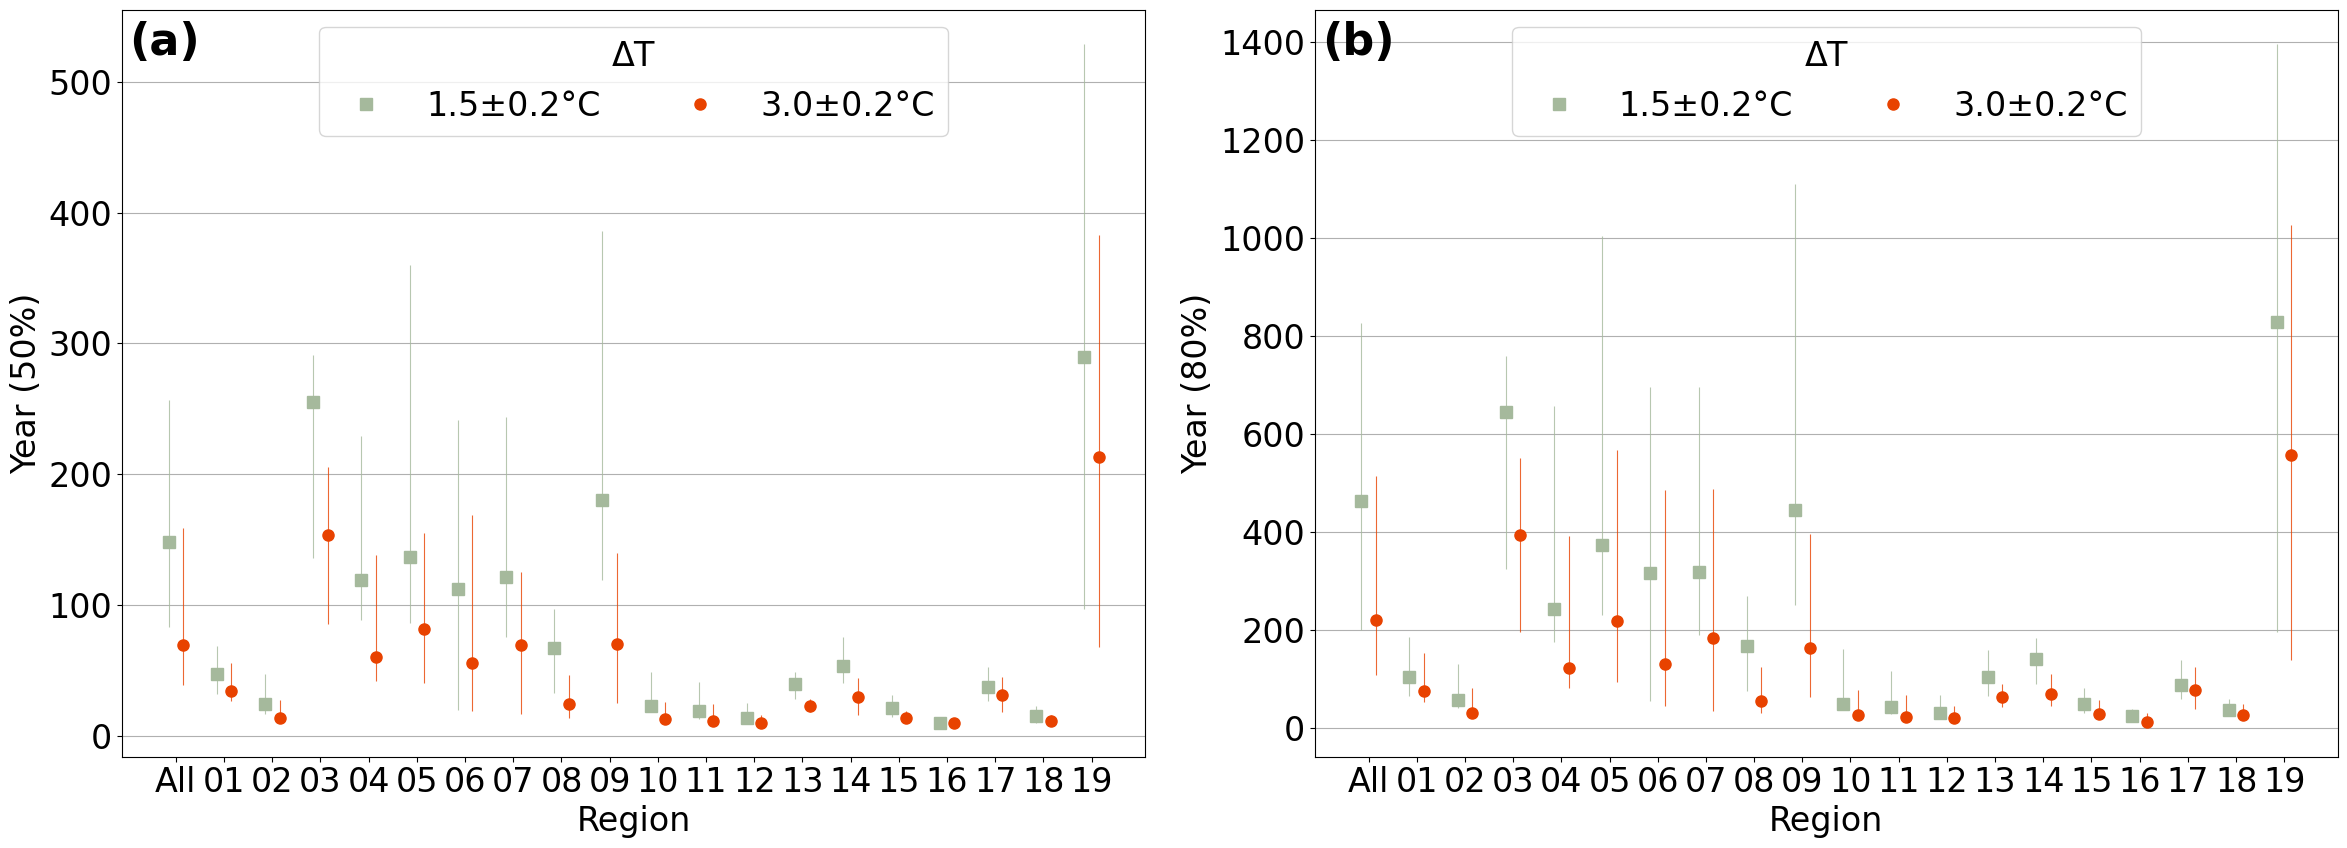

In [15]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors

plt.rc('font', size=24)  
p_add = '_shifted'

markers = ['^', 'X','s','o','D','v']
markers_sel = ['s','o']
markers_sel_d = {'1.5':'s', '3.0':'o'}


glob_temp_ch = get_glob_temp_exp(region='global')['temp_ch_ipcc'].values

from help_functions import cmap, scaler

t = 1.2



col_temp_l_sel_n = [1.2, 1.5, 2.0, 3.0]
cols_n = []
for temp in col_temp_l_sel_n: #,5,6]:
    c=cmap(scaler.transform(np.array(temp).reshape(-1,1)))
    cols_n.append(c)
markers_sel_n = markers_sel #[markers_sel[1],markers_sel[2],markers_sel[3],markers_sel[4]]
#cols_n = sns.color_palette(cols_n)


# it is better to extract that directly, then we can also get the spread already 
_resp_time = pd.read_csv('../data/resp_time_shifted_for_deltaT_rgi_reg_roll_volume_21yravg.csv', index_col=[0])

fig, axs = plt.subplots(1,2, figsize=(24,9))
axs = axs.flatten()
ax = axs[0]
d_temp = 0.2
boxplot = False
for ax,perc in zip(axs,[50, 80]):
    r_l = []

    for j,rgi_reg in enumerate(_resp_time.rgi_reg.unique()):
        _resp_time_r = _resp_time.loc[_resp_time.rgi_reg==rgi_reg]
        for temp,sh in zip([1.5,3.0],[-0.15,+0.15]): 
            color = cmap(scaler.transform(np.array(temp).reshape(-1,1))).squeeze()
            _resp_time_r_temp = _resp_time_r.loc[(_resp_time_r.temp_ch_ipcc>=temp-d_temp) & (_resp_time_r.temp_ch_ipcc<=temp+d_temp)]
            _resp_time_r_temp_sel = _resp_time_r_temp[[f'resp_time_-{perc}%']].quantile([0.05,0.25,0.5,0.75,0.95])
            if boxplot:
                item = {}
                #item["label"] = 'box' # not required
                item["med"] = _resp_time_r_temp_sel.loc[0.50]
                item["q1"] = _resp_time_r_temp_sel.loc[0.25]
                item["q3"] = _resp_time_r_temp_sel.loc[0.75]
                #item["cilo"] = 5.3 # not required
                #item["cihi"] = 5.7 # not required
                item["whislo"] = _resp_time_r_temp_sel.loc[0.05]
                item["whishi"] = _resp_time_r_temp_sel.loc[0.95]
                stats = [item]
                boxprops = dict(linestyle='-', linewidth=1, color=color)
                whisprops = dict(color=color, linewidth=0.5)
                flierprops = dict(marker='o', markerfacecolor='green', markersize=0,
                                  markeredgecolor='none')
                medianprops = dict(linestyle='-', linewidth=3, color=color)
                ax.bxp(stats, positions = [j+sh], #0, #[p + j]
                       showfliers = False,
                        flierprops= flierprops, medianprops=medianprops, boxprops=boxprops,
                         widths=0.25, #patch_artist=True,
                        whiskerprops=whisprops, capprops = dict(color=color, linewidth=0.5))
            else:
                ax.plot([j+sh], [_resp_time_r_temp_sel.loc[0.5].values],
                        markers_sel_d[str(temp)], color = color, ms=8, label = f'{temp}'+r'±0.2°C')
                ax.vlines([j+sh], [_resp_time_r_temp_sel.loc[0.05].values], [_resp_time_r_temp_sel.loc[0.95]], alpha = 0.8, lw=0.8, color = color)
        if j == 0:
            #ax.legend(loc='upper center', title= r'Global warming $\Delta$T of'+f'\n(showing median [5%,95%])', ncol=2)
            ax.legend(loc='upper center', title= r'$\Delta$T', ncol=2) #+f'\n(showing median [5%,95%])'

            #handlesa, labelsb = ax.get_legend_handles_labels()
            #eg = ax.legend([handlesa[0], handlesb[-1]], ['+1.5°C', '+3.0°C'],loc='upper left', title= r'for a $\Delta$T of', ncol=4)
        #r_l_j.append(
        if rgi_reg == 'All':
            r_l.append('All')
        else:
            if boxplot:
                r_l.append(f'  {rgi_reg[3:]}')
                r_l.append('')
            else:
                r_l.append(f'{rgi_reg[3:]}')


    ax.set_xticks(np.arange(0,20,1),r_l)
    ax.grid(axis='y')
    ax.set_xlabel('Region')
    #ax.set_ylabel(f'Simulation years after 2020\nwhen {perc}% of total change occurs')
    ax.set_ylabel(f'Year ({perc}%)')

    
for j,axi in enumerate(axs):
    num_text_x = 0.007
    num_text_y = 0.94

    axi.text(num_text_x, num_text_y,
             num_dict[j], fontsize=32, weight='bold',transform=axi.transAxes)

plt.tight_layout()
#plt.savefig(f'figures/3_response_time/3_resp_time{p_add}_summary_w_uncertainties_{DATE}.png', dpi = 100)

In [16]:
temp = 1.5
d_temp = 0.2
_resp_time_temp = _resp_time.loc[(_resp_time.temp_ch_ipcc>=temp-d_temp) & (_resp_time.temp_ch_ipcc<=temp+d_temp)]
_resp_time_temp['resp_time_-80%'].quantile([0.75])

0.75    282.0
Name: resp_time_-80%, dtype: float64

In [21]:
_resp_time_temp[['resp_time_-80%','rgi_reg']].groupby('rgi_reg').quantile([0.05,0.5,0.95])['resp_time_-80%']

rgi_reg      
All      0.05     199.50
         0.50     463.00
         0.95     827.00
RGI01    0.05      65.00
         0.50     104.00
         0.95     184.80
RGI02    0.05      39.45
         0.50      57.50
         0.95     131.00
RGI03    0.05     323.00
         0.50     644.50
         0.95     759.25
RGI04    0.05     174.00
         0.50     241.50
         0.95     656.50
RGI05    0.05     230.00
         0.50     373.00
         0.95    1003.50
RGI06    0.05      54.15
         0.50     316.00
         0.95     696.00
RGI07    0.05     190.00
         0.50     318.50
         0.95     695.25
RGI08    0.05      75.35
         0.50     166.50
         0.95     269.40
RGI09    0.05     249.75
         0.50     445.00
         0.95    1111.00
RGI10    0.05      37.00
         0.50      47.50
         0.95     159.70
RGI11    0.05      27.00
         0.50      42.50
         0.95     115.85
RGI12    0.05      24.00
         0.50      30.00
         0.95      66.85
RGI13    0.